In [1]:
import pandas, scipy, numpy, seaborn
import matplotlib, matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(8, 5), 'svg.fonttype' : 'none'})

In [3]:
file_directory = "/Users/kja11/OneDrive - Menntaský (1)/Mild_Hypothermia_project/in_silico/Python/"

In [4]:
path = "1) input/RNAseq/"

# II] Data Download

## a. Expression File

In [5]:
#data all_counts_filtered
df_count = pandas.read_csv(file_directory+path+ 'transcript_HEK293_temp_all_counts_unfiltered.tsv',
                     sep = '\t')
print(df_count.shape)
df_count.head()

(135603, 9)


,gene_id,gene_name,feature_id,s37rep2,s32rep3,s37rep1,s37rep3,s32rep1,s32rep2
0,ENSG00000198034,RPS4X,ENST00000316084,232646,199874,190685,196125,160799,177622
1,ENSG00000142937,RPS8,ENST00000396651,191357,163277,156765,160123,133777,150626
2,ENSG00000182774,RPS17,ENST00000647841,188996,163258,157911,153051,133896,156007
3,ENSG00000229117,RPL41,ENST00000546591,182501,170503,142081,168055,126151,146154
4,ENSG00000142937,RPS8,ENST00000485390,182336,155347,148909,154214,126332,142296


In [6]:
# calculate mean
df_count = df_count.assign(mean_32C = (df_count[['s37rep1', 's37rep2', 's37rep3']].mean(axis=1).round(0)),
                           mean_37C = (df_count[['s32rep1', 's32rep2', 's32rep3']].mean(axis=1).round(0))) 

df_count.rename(columns={df_count.columns[2]: 'transcript_id'},inplace=True)
df_count = df_count[['transcript_id','gene_name', 'mean_37C', 'mean_32C']]
print(len(df_count))
df_count.head()

135603


,transcript_id,gene_name,mean_37C,mean_32C
0,ENST00000316084,RPS4X,179432.0,206485.0
1,ENST00000396651,RPS8,149227.0,169415.0
2,ENST00000647841,RPS17,151054.0,166653.0
3,ENST00000546591,RPL41,147603.0,164212.0
4,ENST00000485390,RPS8,141325.0,161820.0


## b. Transcript information file

In [7]:
%%time
#data DETseq HEK293 
df_gtf = pandas.read_csv(file_directory+path+ '20240216_mytranscripts.gtf',
                               sep = '\t', comment='#', header=None)
print(df_gtf.shape)

df_gtf.columns = ["seqname", "source", "feature", "start", "end",
                  "score", "strand", "frame", "attribute"]
df_gtf.head()

<timed exec>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


(2704200, 9)
CPU times: total: 8.48 s
Wall time: 16.7 s


,seqname,source,feature,start,end,score,strand,frame,attribute
0,1,havana,transcript,3069168,3434342,.,+,.,"gene_id ""ENSG00000142611""; gene_version ""17""; ..."
1,1,havana,exon,3069168,3069296,.,+,.,"gene_id ""ENSG00000142611""; gene_version ""17""; ..."
2,1,havana,CDS,3069260,3069296,.,+,0,"gene_id ""ENSG00000142611""; gene_version ""17""; ..."
3,1,havana,start_codon,3069260,3069262,.,+,0,"gene_id ""ENSG00000142611""; gene_version ""17""; ..."
4,1,havana,exon,3186125,3186474,.,+,.,"gene_id ""ENSG00000142611""; gene_version ""17""; ..."


In [8]:
# Only select full transcripts
df_gtf = df_gtf[df_gtf["feature"] == "transcript"]
# extract ID
df_gtf['transcript_id'] = df_gtf['attribute'].str.extract('transcript_id "([^"]+)"')
# Calculate size
df_gtf['transcript_length'] = df_gtf['end'] - df_gtf['start'] + 1

# df_gtf.set_index('transcript_id', inplace = True, drop = True )
df_gtf = df_gtf[['transcript_id', 'transcript_length']]
df_gtf

,transcript_id,transcript_length
0,ENST00000511072,365175
37,ENST00000378391,366225
76,ENST00000514189,365132
113,ENST00000270722,369419
152,ENST00000512462,195995
...,...,...
2704146,ENST00000707304,14213
2704165,ENST00000707305,14219
2704184,ENST00000707306,970
2704189,ENST00000631997,6385


## c. Significant data

In [108]:
#data DEseq HEK293 
df_signif = pandas.read_csv(file_directory+'1) input/RNAseq/from_output/DETranscripts_HEK293_temp_annotated.csv',
                               sep = ',')
print(f'{df_signif.shape} of all transcripts')

signif_transcripts = df_signif[(df_signif.padj < 0.05)].transcript_id
print(f'{len(signif_transcripts)} of significant')

(67460, 13) of all transcripts
702 of significant


# Methods

In [105]:
# pull the DFs
df_plot = df_gtf.merge(df_count)
df_plot.head()

,transcript_id,transcript_length,gene_name,mean_37C,mean_32C
0,ENST00000511072,365175,PRDM16,3.0,0.0
1,ENST00000378391,366225,PRDM16,3.0,0.0
2,ENST00000514189,365132,PRDM16,3.0,0.0
3,ENST00000270722,369419,PRDM16,3.0,0.0
4,ENST00000512462,195995,PRDM16,3.0,0.0


In [106]:
# to not have zero
df_plot.loc[df_plot['mean_37C'] == 0, 'mean_37C'] = 0.01
df_plot.loc[df_plot['mean_32C'] == 0, 'mean_32C'] = 0.01
df_plot.head()

,transcript_id,transcript_length,gene_name,mean_37C,mean_32C
0,ENST00000511072,365175,PRDM16,3.0,0.01
1,ENST00000378391,366225,PRDM16,3.0,0.01
2,ENST00000514189,365132,PRDM16,3.0,0.01
3,ENST00000270722,369419,PRDM16,3.0,0.01
4,ENST00000512462,195995,PRDM16,3.0,0.01


In [112]:
df_plot = df_plot[df_plot['transcript_id'].isin(signif_transcripts)]
print(f'{len(df_plot)} subset of significant')
df_plot.head(2)

702 subset of significant


,transcript_id,transcript_length,gene_name,mean_37C,mean_32C
98,ENST00000375647,79304,ZBTB40,37.0,115.0
99,ENST00000404138,79307,ZBTB40,40.0,117.0


       transcript_length
count         702.000000
mean            4.150834
std             0.595963
min             2.049218
25%             3.738701
50%             4.202457
75%             4.591539
max             5.569642

      Interval  Count
0   1.0 to 1.5      0
1   1.5 to 2.0      0
2   2.0 to 2.5      3
3   2.5 to 3.0     17
4   3.0 to 3.5     83
5   3.5 to 4.0    172
6   4.0 to 4.5    218
7   4.5 to 5.0    168
8   5.0 to 5.5     39
9   5.5 to 6.0      2
10  6.0 to 6.5      0
11  6.5 to 7.0      0


Text(0.5, 0, 'log10(transcript length)')

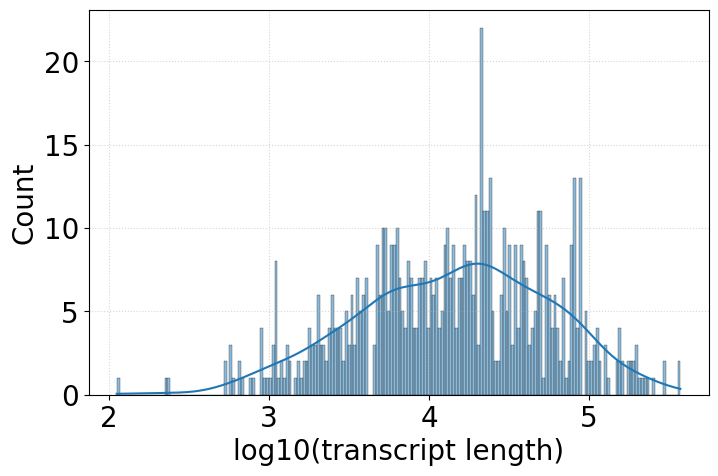

In [118]:
df_hist = df_plot[['transcript_length']].apply(numpy.log10)
values = df_hist.values.flatten()
bin_edges = numpy.arange(1, 7.5, 0.5) # Define the bin edges
hist, edges = numpy.histogram(values, bins=bin_edges) # Calculate the histogram

print(f'{df_hist.describe()}\n')
# Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df)

seaborn.histplot(values, bins=200, kde=True)
plt.xlabel('log10(transcript length)')

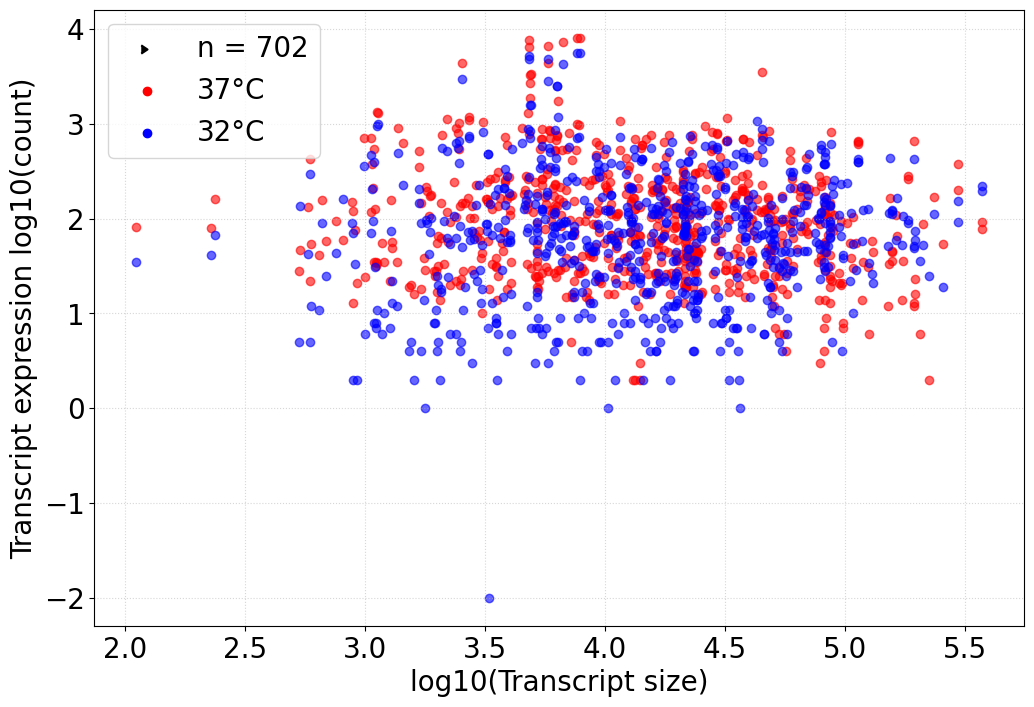

In [125]:
# plot expression on size
expr_37 = df_plot.mean_37C.apply(numpy.log10)
expr_32 = df_plot.mean_32C.apply(numpy.log10)
size = df_plot.transcript_length.apply(numpy.log10)

plt.figure(figsize=(12, 8))
plt.scatter(y = expr_37, x = size, alpha = 0.6, color = 'red')
plt.scatter(x=[],y=[], marker=5, color='k', label= f'n = {len(expr_37)}')
plt.scatter(x=[],y=[], marker="o", color='red', label= f'37°C')

plt.scatter(y = expr_32, x = size, alpha = 0.6, color = 'blue')
plt.scatter(x=[],y=[], marker="o", color='blue', label= f'32°C')

plt.xlabel('log10(Transcript size)')
plt.ylabel('Transcript expression log10(count)')
plt.legend()

Pearson corr score is: 0.9651988487794159, 0.0
Spearman corr score is: 0.8568934874877357, 1.2656756139152445e-203


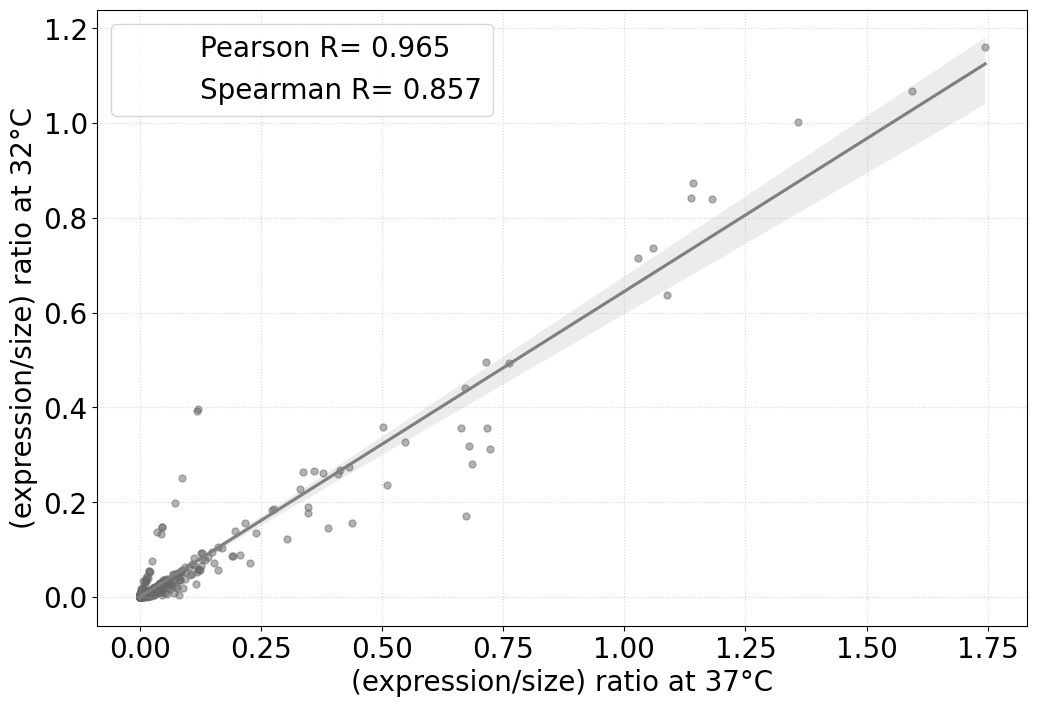

In [126]:
# Calculate correlation score
df_plot = df_plot.assign(ratio_37C = df_plot['mean_37C'] / df_plot['transcript_length'],
                         ratio_32C = df_plot['mean_32C'] / df_plot['transcript_length'])

x= df_plot.ratio_37C
y= df_plot.ratio_32C

#stat Pearson correlation score 
r_value_pcs, p_value_pcs = scipy.stats.pearsonr(x, y)
print(f'Pearson corr score is: {r_value_pcs}, {p_value_pcs}')

#stat Spearman correlation score 
r_value_scs, p_value_scs = scipy.stats.spearmanr(x, y)
print(f'Spearman corr score is: {r_value_scs}, {p_value_scs}')

#graph
plt.figure(figsize=(12, 8))
seaborn.regplot(x=x,y=y, x_ci = 0, marker=".",
                scatter_kws={"color": "dimgrey", "alpha": 0.5, 's': 100}, line_kws={"color": "grey"})

seaborn.regplot(x=[],y=[], marker=" ", 
                label= f'Pearson R= {str(round(r_value_pcs,3))}')

seaborn.regplot(x=[],y=[], marker=" ", 
                label= f'Spearman R= {str(round(r_value_scs,3))}')

plt.xlabel("(expression/size) ratio at 37°C")
plt.ylabel('(expression/size) ratio at 32°C')

plt.legend()

plt.show()  

### DEGs

In [77]:
#data DEseq HEK293 
df_signif = pandas.read_csv(file_directory+'1) input/RNAseq/from_output/DETranscripts_HEK293_temp_annotated.csv',
                               sep = ',')
print(df_signif.shape)

# select the significant one (differentially expressed)
df_signif = df_signif[(df_signif.padj < 0.05)]
print(f'{len(df_signif)} transcripts are significantly different between 37° and 32°C')

df_signif.head()
df_signif.head(2)

(67460, 13)
702 transcripts are significantly different between 37° and 32°C


,transcript_id,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
896,ENST00000295470,HNRNPDL,HNRNPDL-201,ENSG00000152795,protein_coding,protein_coding,heterogeneous nuclear ribonucleoprotein D like...,6861.896999,0.906518,0.239715,3.781649,0.000156,0.019366
897,ENST00000621267,HNRNPDL,HNRNPDL-208,ENSG00000152795,protein_coding,protein_coding,heterogeneous nuclear ribonucleoprotein D like...,6855.061367,0.905946,0.239408,3.784112,0.000154,0.019225


In [81]:
df_signif = df_signif[['transcript_id','Gene name', 'pvalue']]

# pull the DFs
df_plot2 = df_signif.merge(df_gtf)
print(df_plot2.shape)
df_plot2.head()

(702, 4)


,transcript_id,Gene name,pvalue,transcript_length
0,ENST00000295470,HNRNPDL,0.000156,7894
1,ENST00000621267,HNRNPDL,0.000154,7661
2,ENST00000602300,HNRNPDL,0.000060,4813
3,ENST00000502762,HNRNPDL,0.000145,5773
4,ENST00000349655,HNRNPDL,0.000125,4819


Pearson corr score is: 0.07267198980521927, 0.054282071406836135
Spearman corr score is: 0.07375374621004167, 0.050783492069644914


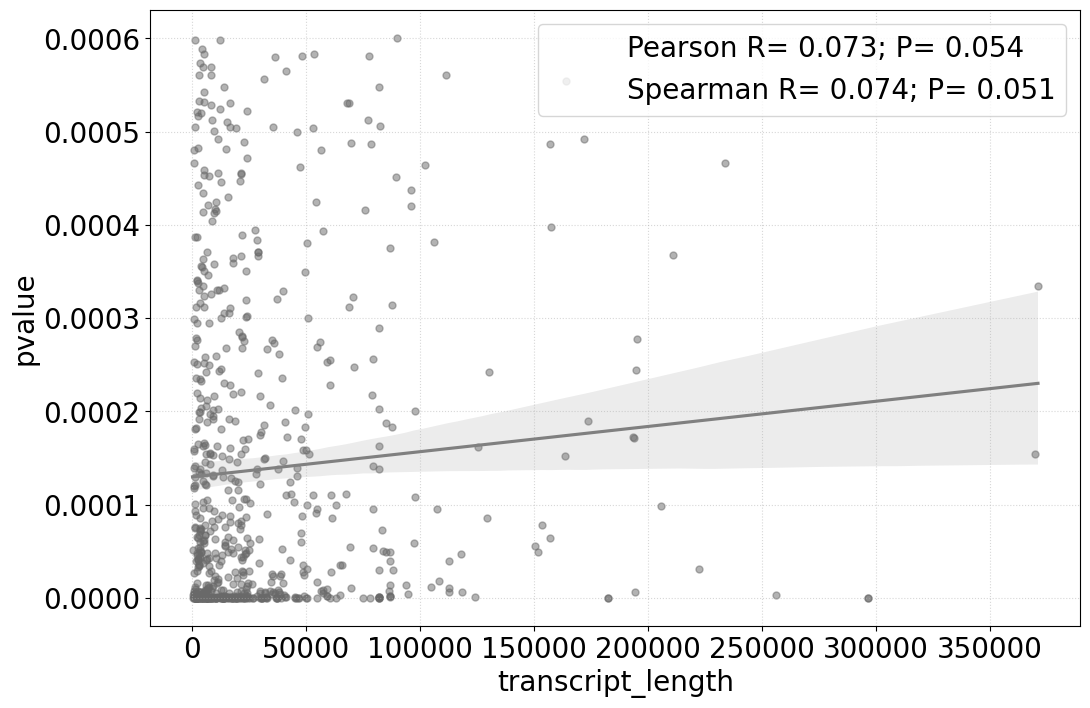

In [82]:
# Is the transcript size correlated to pvalue (differentially expression) ?
# Calculate correlation score
x= df_plot2['transcript_length']
y= df_plot2['pvalue']

#stat Pearson correlation score 
r_value_pcs, p_value_pcs = scipy.stats.pearsonr(x, y)
print(f'Pearson corr score is: {r_value_pcs}, {p_value_pcs}')

#stat Spearman correlation score 
r_value_scs, p_value_scs = scipy.stats.spearmanr(x, y)
print(f'Spearman corr score is: {r_value_scs}, {p_value_scs}')

#graph
plt.figure(figsize=(12, 8))
seaborn.regplot(x=x,y=y, x_ci = 0, marker=".",
                scatter_kws={"color": "dimgrey", "alpha": 0.5, 's': 100}, line_kws={"color": "grey"})

seaborn.regplot(x=[],y=[], marker=" ", 
                label= f'Pearson R= {str(round(r_value_pcs,3))}; P= {str(round(p_value_pcs,3))}')

seaborn.regplot(x=[],y=[], marker=" ", 
                label= f'Spearman R= {str(round(r_value_scs,3))}; P= {str(round(p_value_scs,3))}')

plt.xlabel("transcript_length")
plt.ylabel('pvalue')

plt.legend()

plt.show()  